# Mask R-CNN for Human Pose Estimation Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Add root to path 
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# Import Mask RCNN
# from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

# Import pantogrograph class
from dev import pantograph

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "models")

# Set path to root of images. 
DATA_DIR = os.path.join(ROOT_DIR, "datasets/pantograph")

# # Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

print("Using Root dir:",ROOT_DIR)
print("Using Model dir:",MODEL_DIR)
print("Using Data dir:",DATA_DIR)

/Users/jessedecker/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jessedecker/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jessedecker/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jessedecker/miniconda3/envs/tf

I've been imported
Using Root dir: /Users/jessedecker/projects/rail_segmentation
Using Model dir: /Users/jessedecker/projects/rail_segmentation/models
Using Data dir: /Users/jessedecker/projects/rail_segmentation/datasets/pantograph


Using TensorFlow backend.


## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [2]:
class InferenceConfig(pantograph.PantographConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    KEYPOINT_MASK_POOL_SIZE = 7

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = model.find_last()[1]

# Local path to trained weights file
MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_pantograph_0017.h5")

# Load trained weights (fill in path to trained weights here)
print("Loading weights from ", MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /Users/jessedecker/projects/rail_segmentation/models/mask_rcnn_pantograph_0017.h5


## Dataset

In [3]:
# Load dataset
dataset = pantograph.PantographDataset()
dataset.load_pantograph(DATA_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))

for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Skeleton: (5, 2)
Keypoint names: (6,)
Image Count: 8
Class Count: 4
  0. BG                                                
  1. front_bar                                         
  2. middle_bar                                        
  3. rear_bar                                          


### Ground Truth Test Images

image_id  5 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/val/swin_to_padd_frame_96772.jpg


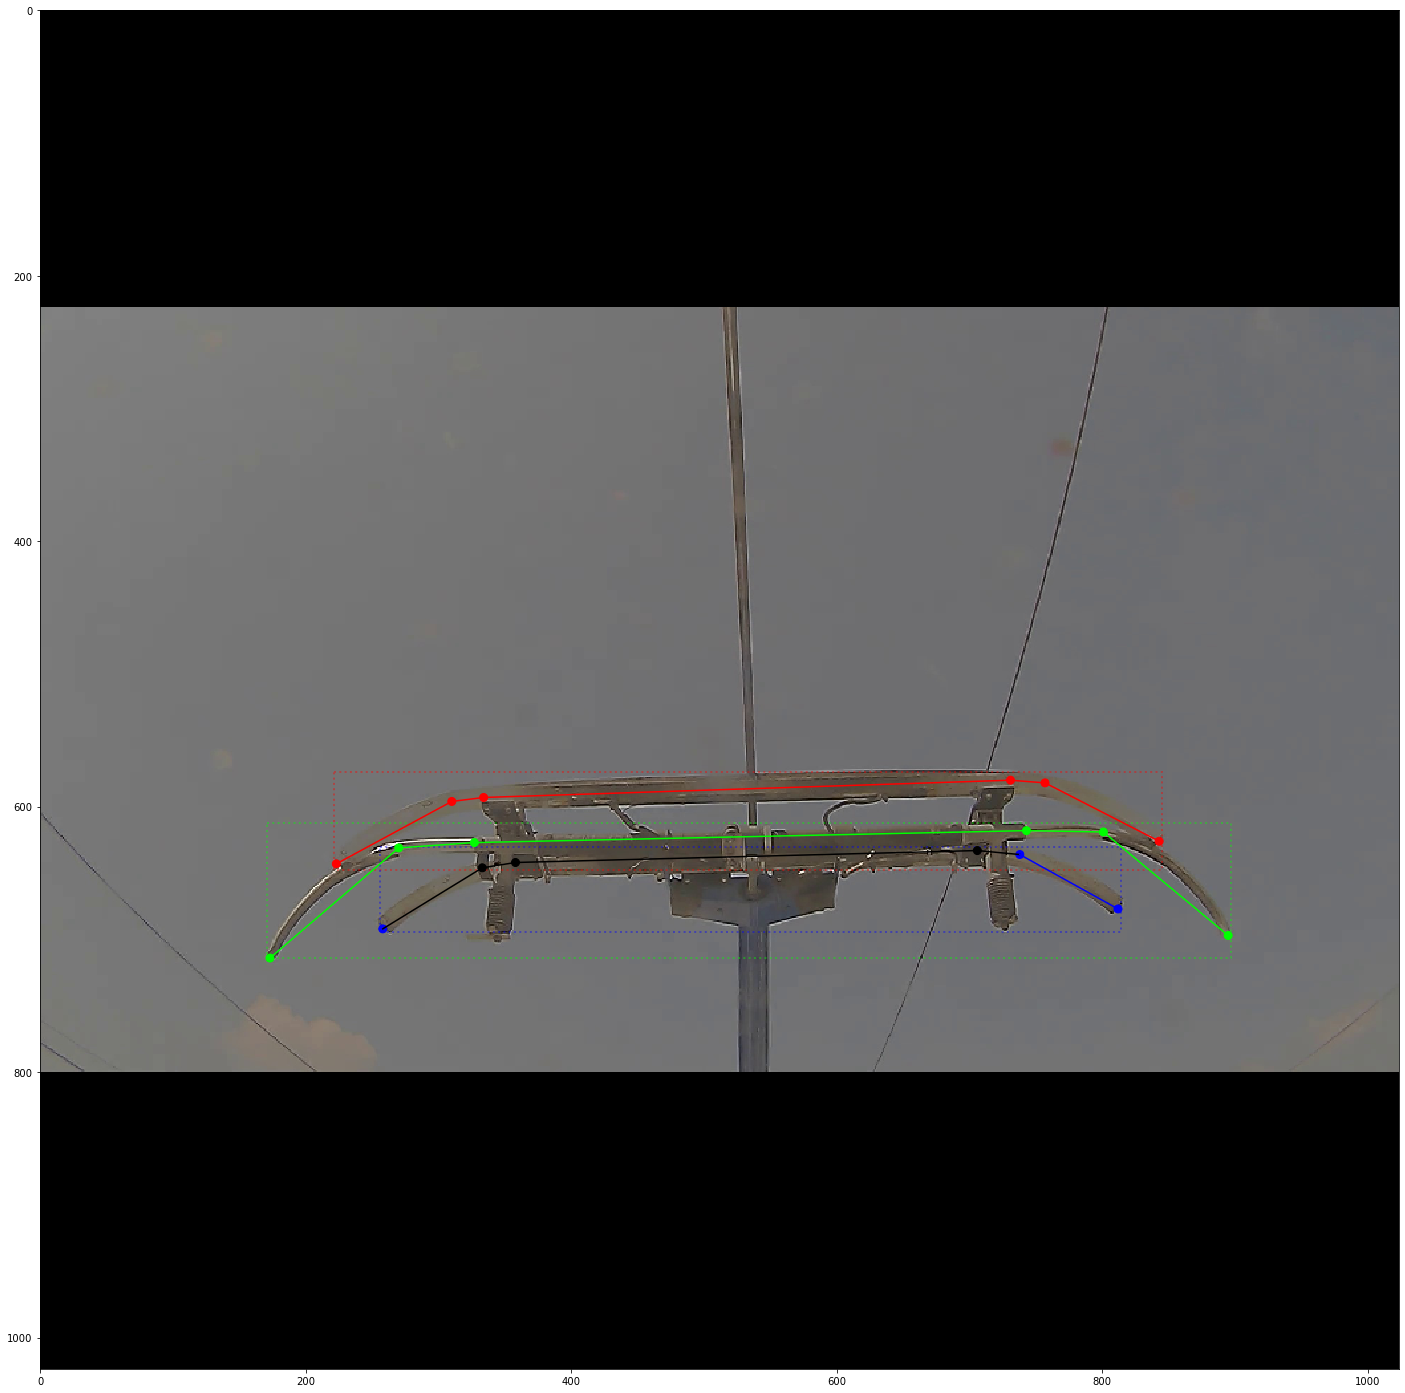

In [4]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))

image = dataset.load_image(image_id)
keypoints, masks, class_ids = dataset.load_keypoints(image_id)
bbox = utils.extract_bboxes(masks)

# Use below to prep image for detection.
image, image_meta, gt_class_id, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, inference_config, 
                           image_id, augment=False,use_mini_mask=inference_config.USE_MINI_MASK) #inference_config.USE_MINI_MASK


# 1=front_bar,2=middle_bar, 3=rear_bar
categories = [0,1,2]

# 1=bbox,2=masks, 3=keypoints
annotations = [1,2,3]

anno_obj = {
    'bbox':bbox,
    'color':[(255,0,0),(0,255,0),(0,0,255)],
    'segmentation':masks,
    'keypoints':keypoints,
    'skeleton':dataset.skeleton,
}

visualize.DrawAnnotations(image, categories, annotations,anno_obj)

## Detection

In [ ]:
# results = model.detect([image], verbose=1)

image, image_meta, _, _, _ = modellib.load_image_gt(dataset, inference_config, image_id)
results = model.detect_keypoint([image], verbose=1)

r = results[0] # for one image

# 1=front_bar,2=middle_bar, 3=rear_bar
categories = [0,1,2]

# 1=bbox,2=masks, 3=keypoints
annotations = [1,2,3]

anno_obj = {
    'bbox':r['rois'],
    'color':[(255,0,0),(0,255,0),(0,0,255)],
    'segmentation':r['masks'],
    'keypoints':r['keypoints'],
    'skeleton':dataset.skeleton,
}

visualize.DrawAnnotations(image, categories, annotations,anno_obj)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
Molding Inputs
(1, 1024, 1024, 3)
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 12)               min:    0.00000  max: 1024.00000
windows                  shape: (1, 4)                min:    0.00000  max: 1024.00000
Starting Detection

